In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import squidpy as sq
from sklearn.metrics.pairwise import cosine_similarity
import statistics
import pandas as pd
import json

/home/apon/anaconda3/envs/cell2loc-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/apon/anaconda3/envs/cell2loc-env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
!pwd

/home/apon/thesis/ct_dist_tg_vs_c2loc/scripts_lucas_data


In [3]:
cell2loc_results = sc.read_h5ad("../results/cell2location_map_lucas_data/sp_lucas_data.h5ad") #read cell2loc results

In [4]:
cell2loc_results

AnnData object with n_obs × n_vars = 2695 × 762
    obs: 'X', 'Y', 'cell_type', 'Cell_type', 'Cell_Type', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_id', 'p_val', 'q_val', 'SYMBOL', 'MT_gene'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'centroids', 'mod'
    obsm: 'MT', 'cell_type_distribution', 'cell_type_distributions', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [6]:
#cell2loc_results.obsm["means_cell_abundance_w_sf"]
max_values = cell2loc_results.obsm["means_cell_abundance_w_sf"].max(axis=1)
print("MAX values row-wise:", max_values)

#cell2loc_results.obsm["means_cell_abundance_w_sf"]
sum_values = cell2loc_results.obsm["means_cell_abundance_w_sf"].sum(axis=1)
print("SUM values row-wise:", sum_values)



MAX values row-wise: AAACAAGTATCTCCCA-1    1.157404
AAACACCAATAACTGC-1    1.138877
AAACAGAGCGACTCCT-1    4.140468
AAACAGCTTTCAGAAG-1    5.723714
AAACAGGGTCTATATT-1    5.436673
                        ...   
TTGTGTTTCCCGAAAG-1    1.613756
TTGTTCAGTGTGCTAC-1    3.487089
TTGTTGTGTGTCAAGA-1    0.930299
TTGTTTCACATCCAGG-1    2.294354
TTGTTTCCATACAACT-1    2.267529
Length: 2695, dtype: float32
SUM values row-wise: AAACAAGTATCTCCCA-1     3.308007
AAACACCAATAACTGC-1     5.625088
AAACAGAGCGACTCCT-1     8.673882
AAACAGCTTTCAGAAG-1     7.537528
AAACAGGGTCTATATT-1     7.366508
                        ...    
TTGTGTTTCCCGAAAG-1     5.161155
TTGTTCAGTGTGCTAC-1    12.021923
TTGTTGTGTGTCAAGA-1     3.864721
TTGTTTCACATCCAGG-1     6.691077
TTGTTTCCATACAACT-1     7.150645
Length: 2695, dtype: float32


In [25]:
cell2loc_results.obsm["means_cell_abundance_w_sf"].sum(axis=1).mean()

np.float32(5.889345)

In [24]:
cell2loc_results.obsm

AxisArrays with keys: MT, cell_type_distribution, cell_type_distributions, means_cell_abundance_w_sf, q05_cell_abundance_w_sf, q95_cell_abundance_w_sf, spatial, stds_cell_abundance_w_sf

In [9]:
cell2loc_matrix = cell2loc_results.obsm["means_cell_abundance_w_sf"] #get cell2location results

cell2loc_matrix = cell2loc_matrix.T  #transpose matrix so I can compare to tg

cell2loc_dist = cell2loc_matrix.div(cell2loc_matrix.sum(axis=0), axis=1) #normalize so each row sums up to 1


In [10]:
#tg_dist = np.loadtxt("tg_ct_dist.txt") #load tg results
tg_dist = np.loadtxt("../results/tg_ct_dist_no_thresh_lucas_data.txt") #load tg results


In [11]:
tg_dist.shape == cell2loc_dist.shape

True

In [12]:
tg = tg_dist  # already a NumPy array
c2l = cell2loc_dist.values  # convert pandas DataFrame to NumPy

# Similarity per spot (column-wise comparison)
similarity = [
    cosine_similarity(tg[:, [i]].T, c2l[:, [i]].T)[0, 0]
    for i in range(tg.shape[1])
]

correlations = [
    np.corrcoef(tg[:, i], c2l[:, i])[0, 1]
    for i in range(tg.shape[1])
]

(array([ 79.,  89., 240., 428., 546., 454., 438., 311.,  98.,  12.]),
 array([0.0408211 , 0.11222658, 0.18363206, 0.25503754, 0.32644302,
        0.3978485 , 0.46925398, 0.54065946, 0.61206494, 0.68347042,
        0.7548759 ]),
 <BarContainer object of 10 artists>)

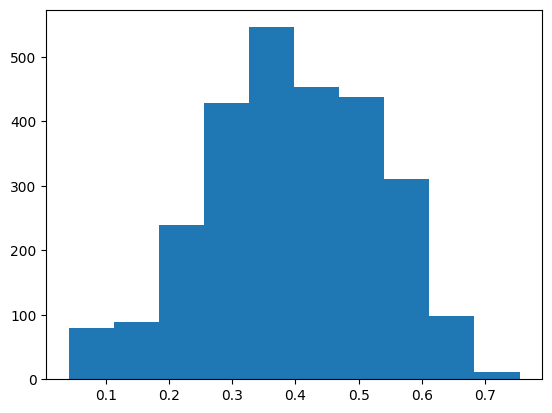

In [13]:
plt.hist(similarity)

(array([ 21., 349., 556., 491., 397., 387., 358., 112.,  20.,   4.]),
 array([-0.3278154 , -0.23153993, -0.13526446, -0.03898899,  0.05728648,
         0.15356195,  0.24983742,  0.34611289,  0.44238836,  0.53866383,
         0.6349393 ]),
 <BarContainer object of 10 artists>)

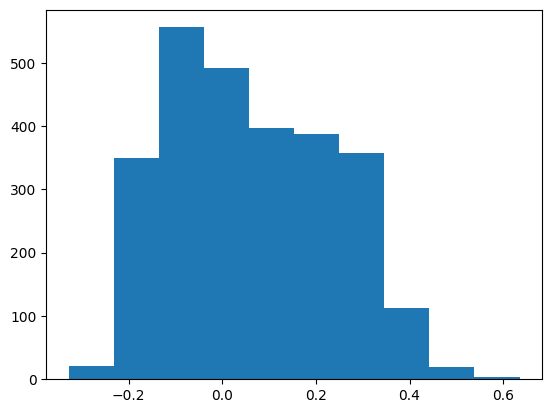

In [14]:
plt.hist(correlations)

In [15]:
cell2loc_results.obsm["spatial"]

array([[7474., 8500.],
       [8552., 2788.],
       [3163., 7950.],
       ...,
       [5199., 6780.],
       [8433., 4371.],
       [6876., 3339.]])

/tmp/ipykernel_3778251/1947020714.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


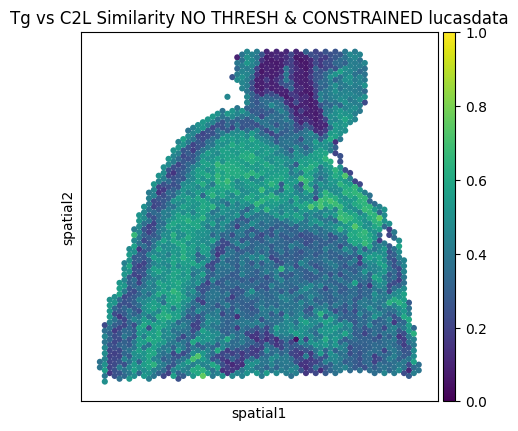

In [16]:
# Add similarity metric as a new column in .obs
cell2loc_results.obs['tg_vs_c2l_similarity'] = similarity  # or correlations


# Ensure similarity is in .obs
cell2loc_results.obs['tg_vs_c2l_similarity'] = similarity

sc.pl.spatial(
    cell2loc_results,
    color="tg_vs_c2l_similarity",
    img_key=None,
    size=1.5,
    spot_size=100,
    cmap="viridis",
    title="Tg vs C2L Similarity NO THRESH & CONSTRAINED lucasdata",
    vmin=0,
    vmax=1,
    show=True
)



# Cell2location ct distribution

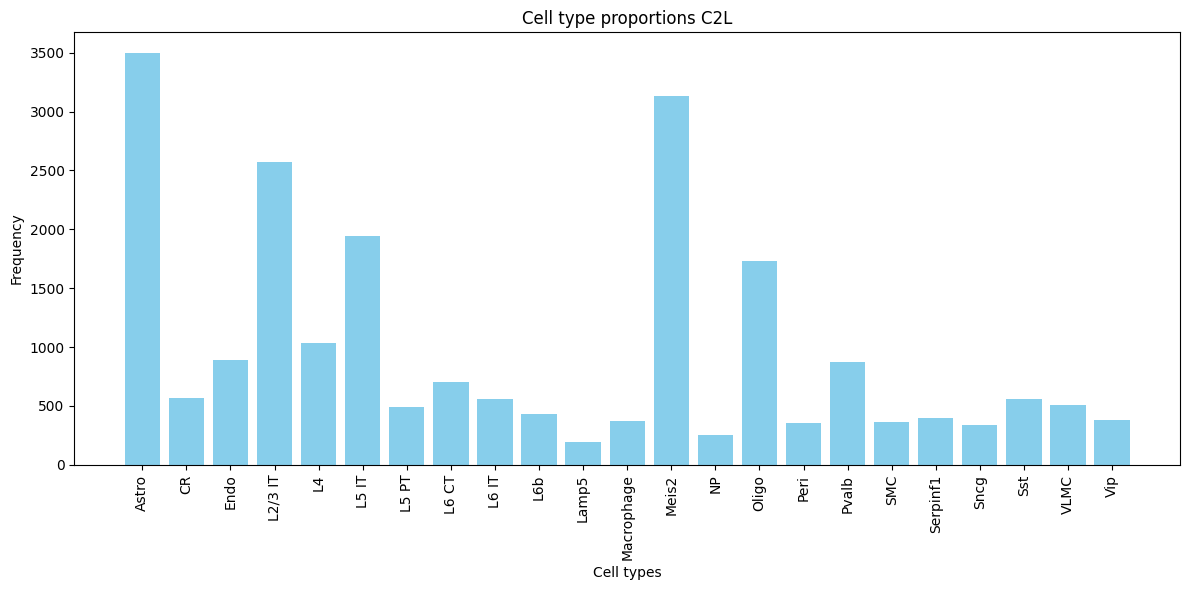

In [17]:
cell_abundance = cell2loc_results.obsm['means_cell_abundance_w_sf'] #c2l results

cell_abundance_df = pd.DataFrame( # Convert to DataFrame for easy handling (optional but useful)
    cell_abundance, 
    index=cell2loc_results.obs_names, 
    columns=cell2loc_results.obsm['means_cell_abundance_w_sf'].dtype.names 
    if hasattr(cell2loc_results.obsm['means_cell_abundance_w_sf'], 'dtype') else cell2loc_results.obsm['means_cell_abundance_w_sf'].columns
)


# UNCOMMENT FOR PROBABILITY DISTRIBUTION (L1 NORMALIZATION)

cell_type_totals = cell_abundance_df.sum(axis=0) #get total abundance per ct

cell_type_totals = cell_type_totals.sort_index() #sort descending

#cell_type_totals /= cell_type_totals.sum() #compute proportions

cell_type_totals.index = cell_type_totals.index.str.split('_fg_').str[-1]



# Plot
plt.figure(figsize=(12, 6))
plt.bar(cell_type_totals.index, cell_type_totals.values, color='skyblue')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel('Cell types')
plt.ylabel('Frequency')
plt.title('Cell type proportions C2L')
plt.tight_layout()
plt.show()



# Comparing sc and c2l proportions 

In [19]:
from collections import Counter

adata_sc = sc.read('../../lucas_data/SC_REF_for_VISIUM_preprocessed.h5ad')

sc_abundance = Counter(adata_sc.obs.cell_type)

sc_abundance = dict(sorted(sc_abundance.items()))


In [45]:
############     IF YOU HAVE JSON FILE WITH CT COUNTS ################
with open('ct_abundance_sc.json', 'r') as f:
    sc_abundance = json.load(f)

sc_abundance = dict(sorted(sc_abundance.items()))


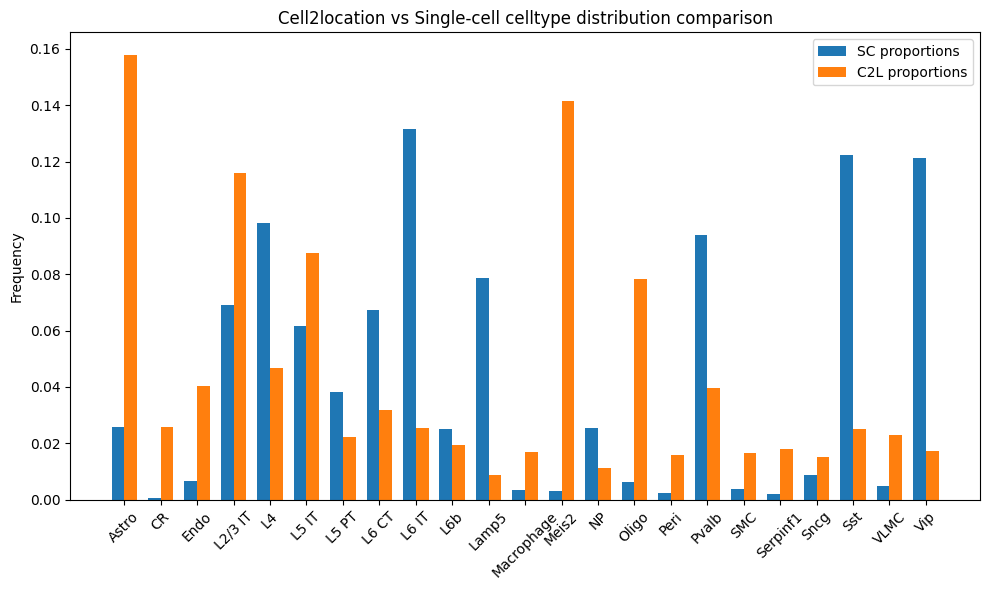

In [45]:
categories = list(sc_abundance.keys())

#get ct proportions
sc_total = sum(sc_abundance.values())
sc_props = {k: v / sc_total for k, v in sc_abundance.items()}

cell_type_totals = cell2loc_results.obsm["means_cell_abundance_w_sf"].sum(axis=0)
c2l_total = cell_type_totals.sum()
c2l_props = (cell_type_totals / c2l_total).to_dict()

#Plot
x = np.arange(len(categories))                 # The label locations
width = 0.35                                   # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, list(sc_props.values()), width, label='SC proportions')
bars2 = ax.bar(x + width/2, list(c2l_props.values()), width, label='C2L proportions')

# Labels, title and custom x-axis tick labels
ax.set_ylabel('Frequency')
ax.set_title('Cell2location vs Single-cell celltype distribution comparison')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

# Comparing sc and c2l proportions RAW

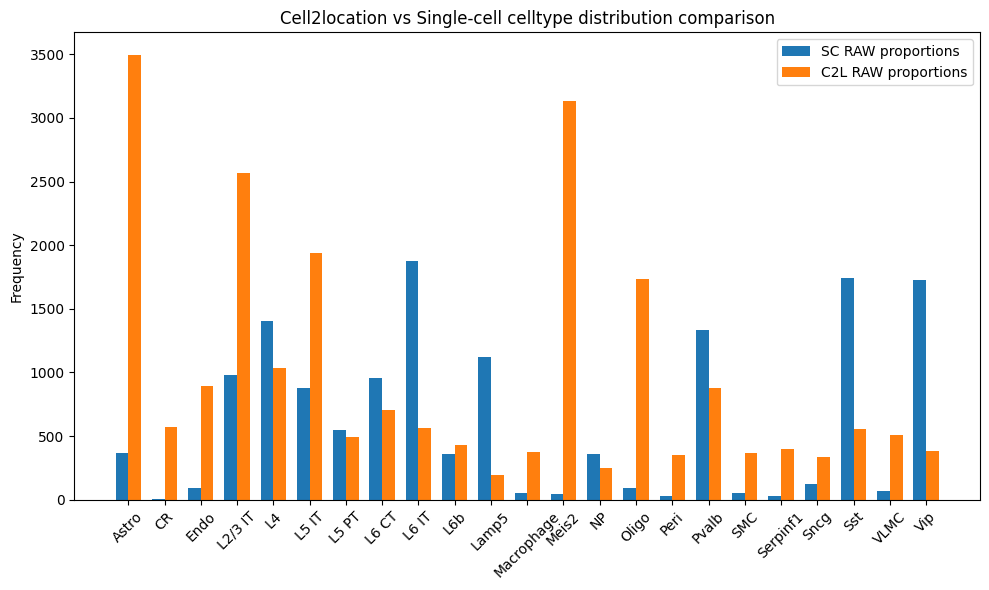

In [21]:
categories = list(sc_abundance.keys()) #get celltypes

x = np.arange(len(categories))                 # The label locations
width = 0.35                                   # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, list(sc_abundance.values()), width, label='SC RAW proportions')
bars2 = ax.bar(x + width/2, cell_type_totals.values, width, label='C2L RAW proportions')

# Labels, title and custom x-axis tick labels
ax.set_ylabel('Frequency')
ax.set_title('Cell2location vs Single-cell celltype distribution comparison')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

In [22]:
print("Total cells in sc:", sum(sc_abundance.values()))
print("Total cells estimated by C2L:", sum(cell_type_totals.values))

Total cells in sc: 14249
Total cells estimated by C2L: 22147.82


# TEST (DELETE)

In [34]:
!pwd

/home/apon/thesis/ct_dist_tg_vs_c2loc/scripts_lucas_data


In [35]:
adata_st = sc.read('../../lucas_data/Visium_Mouse_Brain_SPAPROS_filtered_celltypes_annotated.h5ad')


In [44]:

print(adata_st.obsm["cell_type_distribution"].iloc[[0]])

                    q05cell_abundance_w_sf_Astro  q05cell_abundance_w_sf_CR  \
AAACAAGTATCTCCCA-1                      0.000941                    0.00003   

                    q05cell_abundance_w_sf_Endo  \
AAACAAGTATCTCCCA-1                     0.000046   

                    q05cell_abundance_w_sf_L2/3 IT  q05cell_abundance_w_sf_L4  \
AAACAAGTATCTCCCA-1                        0.000028                   0.000027   

                    q05cell_abundance_w_sf_L5 IT  \
AAACAAGTATCTCCCA-1                      0.000028   

                    q05cell_abundance_w_sf_L5 PT  \
AAACAAGTATCTCCCA-1                      0.000028   

                    q05cell_abundance_w_sf_L6 CT  \
AAACAAGTATCTCCCA-1                      0.000027   

                    q05cell_abundance_w_sf_L6 IT  q05cell_abundance_w_sf_L6b  \
AAACAAGTATCTCCCA-1                      0.000027                    0.000028   

                    ...  q05cell_abundance_w_sf_NP  \
AAACAAGTATCTCCCA-1  ...                   0.0